In [1]:
!pip install scikeras
from scikeras.wrappers import KerasClassifier, KerasRegressor
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.model_selection import GridSearchCV

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 42.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


In [2]:
df=pd.read_csv("/content/DataFrame.csv",parse_dates=["Timestamp"],index_col=[0])

<ipython-input-2-4286302d6d8c>:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df=pd.read_csv("/content/DataFrame.csv",parse_dates=["Timestamp"],index_col=[0])


In [3]:
print(df.index.freq)

None


In [4]:
df = df.drop(columns=['Policy_rate'])

In [66]:
# import pandas as pd

# # สมมติว่ามี DataFrame ชื่อ df ที่คอลัมน์ 'Date' คือวันที่ และ 'Value' คือค่าของข้อมูล
# # df['Timestamp'] = pd.to_datetime(df['Timestamp'])  # แปลงคอลัมน์ Date ให้เป็น datetime
# # df.set_index('Timestamp', inplace=True)  # ตั้ง 'Date' เป็น index

# # ใช้ resample เพื่อแปลงข้อมูลเป็นรายเดือน (M)
# monthly_df = df.resample('M').mean()  # แปลงข้อมูลเป็นรายเดือนโดยใช้ค่าเฉลี่ย

# # หากต้องการใช้ฟังก์ชันอื่นเช่น ผลรวม
# monthly_df_sum = df.resample('M').sum()  # ผลรวมของข้อมูลรายเดือน


In [68]:
# monthly_df.to_csv("/content/monthly_df.csv")

In [5]:
df.describe()

,Gold_price,Exchange_mid_rate,price_index,Xau_Price
count,3394.000000,3394.000000,3394.000000,3394.000000
mean,23999.616971,33.312501,100.679110,1518.660899
std,5563.686139,1.879509,3.815625,323.058992
min,17850.000000,29.804000,96.600000,1051.740000
25%,19600.000000,31.830900,97.920000,1252.737500
50%,21000.000000,32.979550,99.360000,1338.375000
75%,28450.000000,34.948650,101.860000,1811.567500
max,41700.000000,38.338000,108.840000,2425.120000


In [6]:
df.shape

(3394, 4)

In [7]:
df.head()

,Gold_price,Exchange_mid_rate,price_index,Xau_Price
Timestamp,,,,
2013-07-23,19500,30.9172,96.61,1348.10
2013-07-24,19650,30.9118,96.61,1321.30
2013-07-25,19400,31.0756,96.61,1333.65
2013-07-26,19650,31.0994,96.61,1333.90
2013-07-27,19650,31.0994,96.61,1333.90


In [8]:
df.tail()

,Gold_price,Exchange_mid_rate,price_index,Xau_Price
Timestamp,,,,
2024-06-25,40500,36.6043,108.5,2319.01
2024-06-26,40400,36.7679,108.5,2297.91
2024-06-27,40350,36.9374,108.5,2327.45
2024-06-28,40500,36.8497,108.5,2325.71
2024-06-29,40500,36.8497,108.5,2325.71


In [9]:
test_split=round(len(df)*0.2)

In [10]:
scaler = MinMaxScaler(feature_range=(0,1))
df_scaled = scaler.fit_transform(df)

In [11]:
df_scaled.shape

(3394, 4)

In [12]:
test_split

679

In [13]:
df_for_training=df_scaled[:-test_split]
df_for_testing=df_scaled[-test_split:]

In [14]:
print(df_for_training.shape)
print(df_for_testing.shape)

(2715, 4)
(679, 4)


In [15]:
df_scaled[0]

array([0.06918239, 0.13044293, 0.00081699, 0.21578878])

In [16]:
df_for_testing[0]

array([0.54507338, 0.5321303 , 0.69852941, 0.61502279])

In [17]:
def createXY(dataset,n_past,future):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)-future):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i-1:i+future-1,0])
    return np.array(dataX),np.array(dataY)

In [18]:
trainX,trainY=createXY(df_for_training,30,5)

In [19]:
trainX.shape

(2680, 30, 4)

In [20]:
testX,testY=createXY(df_for_testing,30,5)

In [21]:
testX.shape

(644, 30, 4)

In [22]:
trainX[0]

array([[0.06918239, 0.13044293, 0.00081699, 0.21578878],
       [0.0754717 , 0.12981017, 0.00081699, 0.19627488],
       [0.06498952, 0.14900398, 0.00081699, 0.2052673 ],
       [0.0754717 , 0.15179283, 0.00081699, 0.20544933],
       [0.0754717 , 0.15179283, 0.00081699, 0.20544933],
       [0.0754717 , 0.15921022, 0.00081699, 0.20086211],
       [0.07337526, 0.16917038, 0.00081699, 0.20064367],
       [0.08176101, 0.18115772, 0.00081699, 0.19758552],
       [0.0754717 , 0.17153738, 0.        , 0.18728247],
       [0.05660377, 0.18576283, 0.        , 0.18950327],
       [0.06918239, 0.18576283, 0.        , 0.18950327],
       [0.06918239, 0.17709163, 0.        , 0.18364182],
       [0.06079665, 0.18527068, 0.        , 0.16758654],
       [0.05031447, 0.19177408, 0.        , 0.1718461 ],
       [0.05450734, 0.17816967, 0.        , 0.18950327],
       [0.06498952, 0.16511601, 0.        , 0.1913236 ],
       [0.06708595, 0.16511601, 0.        , 0.1913236 ],
       [0.07337526, 0.16511601,

In [23]:
print("trainX Shape-- ",trainX.shape)
print("trainY Shape-- ",trainY.shape)

trainX Shape--  (2680, 30, 4)
trainY Shape--  (2680, 5)


In [24]:
print("testX Shape-- ",testX.shape)
print("testY Shape-- ",testY.shape)

testX Shape--  (644, 30, 4)
testY Shape--  (644, 5)


In [25]:
print("trainX[0]-- \n",trainX[0])
print("\ntrainY[0]-- ",trainY[0])

trainX[0]-- 
 [[0.06918239 0.13044293 0.00081699 0.21578878]
 [0.0754717  0.12981017 0.00081699 0.19627488]
 [0.06498952 0.14900398 0.00081699 0.2052673 ]
 [0.0754717  0.15179283 0.00081699 0.20544933]
 [0.0754717  0.15179283 0.00081699 0.20544933]
 [0.0754717  0.15921022 0.00081699 0.20086211]
 [0.07337526 0.16917038 0.00081699 0.20064367]
 [0.08176101 0.18115772 0.00081699 0.19758552]
 [0.0754717  0.17153738 0.         0.18728247]
 [0.05660377 0.18576283 0.         0.18950327]
 [0.06918239 0.18576283 0.         0.18950327]
 [0.06918239 0.17709163 0.         0.18364182]
 [0.06079665 0.18527068 0.         0.16758654]
 [0.05031447 0.19177408 0.         0.1718461 ]
 [0.05450734 0.17816967 0.         0.18950327]
 [0.06498952 0.16511601 0.         0.1913236 ]
 [0.06708595 0.16511601 0.         0.1913236 ]
 [0.07337526 0.16511601 0.         0.20726966]
 [0.07966457 0.17037731 0.         0.19627488]
 [0.0754717  0.17616592 0.         0.2063959 ]
 [0.08176101 0.16873682 0.         0.22885873]

In [26]:
trainY[1]

array([0.15303983, 0.16561845, 0.15303983, 0.14255765, 0.14465409])

In [27]:
trainY.shape

(2680, 5)

In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

ModuleNotFoundError: No module named 'keras.wrappers'

In [28]:
trainX.shape[1]

30

In [ ]:
def build_model(optimizer='adam'):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
    model.add(LSTM(50,return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50,return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(trainY.shape[1]))

    model.compile(loss='mse', optimizer=optimizer)
    return model

# กำหนด Keras Regressor
model = KerasRegressor(model=build_model, verbose=1)

# พารามิเตอร์สำหรับ GridSearchCV
parameters = {
    'batch_size': [16, 20,30],
    'epochs': [8, 10,12,15,30],
    'optimizer': ['adam', 'Adadelta']
}

# ตั้งค่า GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=parameters, cv=2)

# ฝึกโมเดลด้วย GridSearchCV
grid_search.fit(trainX, trainY, validation_data=(testX, testY))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - loss: 0.0179 - val_loss: 0.0057
Epoch 2/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.0030 - val_loss: 0.0058
Epoch 3/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0024 - val_loss: 0.0089
Epoch 4/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - loss: 0.0021 - val_loss: 0.0055
Epoch 5/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 0.0020 - val_loss: 0.0097
Epoch 6/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 0.0015 - val_loss: 0.0084
Epoch 7/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0015 - val_loss: 0.0203
Epoch 8/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - loss: 0.0018 - val_loss: 0.0059
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 16s 105ms/step - loss: 0.0026 - val_loss: 0.0259
Epoch 2/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 5.9865e-04 - val_loss: 0.0270
Epoch 3/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 4.8456e-04 - val_loss: 0.0182
Epoch 4/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - loss: 4.2320e-04 - val_loss: 0.0064
Epoch 5/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 3.6808e-04 - val_loss: 0.0056
Epoch 6/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 2.7878e-04 - val_loss: 0.0028
Epoch 7/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 2.5867e-04 - val_loss: 0.0083
Epoch 8/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 2.2781e-04 - val_loss: 0.0059
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - loss: 0.0227 - val_loss: 0.0075
Epoch 2/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - loss: 0.0034 - val_loss: 0.0064
Epoch 3/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.0025 - val_loss: 0.0064
Epoch 4/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0021 - val_loss: 0.0079
Epoch 5/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0017 - val_loss: 0.0055
Epoch 6/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 0.0017 - val_loss: 0.0062
Epoch 7/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0015 - val_loss: 0.0054
Epoch 8/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.0012 - val_loss: 0.0075
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 16s 105ms/step - loss: 0.0024 - val_loss: 0.0510
Epoch 2/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 5.7975e-04 - val_loss: 0.0278
Epoch 3/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 4.3856e-04 - val_loss: 0.0270
Epoch 4/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 3.9043e-04 - val_loss: 0.0036
Epoch 5/8
36/84 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 3.6699e-04

In [133]:
grid_search.best_params_

{'batch_size': 16, 'epochs': 8, 'optimizer': 'adam'}

In [134]:
my_model=grid_search.best_estimator_.model_

In [135]:
my_model

<Sequential name=sequential_222, built=True>

In [136]:
prediction=my_model.predict(testX)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


In [137]:
print("prediction\n", prediction)
print("testY\n",testY)
print("\nPrediction Shape-",prediction.shape)

prediction
 [[0.4065784  0.4333956 ]
 [0.40410155 0.43230957]
 [0.40682366 0.436212  ]
 [0.42188475 0.45195633]
 [0.43775928 0.46813443]
 [0.46225274 0.4920006 ]
 [0.4885373  0.51718926]
 [0.50837535 0.535557  ]
 [0.52090365 0.5463177 ]
 [0.5246927  0.5484832 ]
 [0.5331731  0.555123  ]
 [0.53786427 0.5588623 ]
 [0.5361995  0.55698735]
 [0.53896093 0.55946827]]
testY
 [[0.51816477 0.57228816]
 [0.57228816 0.6279756 ]
 [0.6279756  0.62207385]
 [0.62207385 0.61669393]
 [0.61669393 0.60881902]
 [0.60881902 0.60319815]
 [0.60319815 0.63364212]
 [0.63364212 0.65906439]
 [0.65906439 0.66950722]
 [0.66950722 0.68765376]
 [0.68765376 0.69502143]
 [0.69502143 0.71672931]
 [0.71672931 0.82409521]
 [0.82409521 0.99597378]]

Prediction Shape- (14, 2)


In [138]:
prediction.shape

(14, 2)

In [139]:
def resha(data,future):
  final = []
  for i in range(0, data.shape[0], future):
    for j in range(data.shape[1]):
                final.append(data[i,j])
  return np.array(final)


In [140]:
array_predict=resha(prediction,5)

In [141]:
array_actual = resha(testY,5)

In [142]:
array_predict.shape

(14,)

In [143]:
reshaped_predict = np.tile(array_predict.reshape(-1, 1), df_for_testing.shape[1])

In [144]:
reshaped_actual = np.tile(array_actual.reshape(-1, 1), df_for_testing.shape[1])

In [145]:
reshaped_predict[0]

array([0.4065784, 0.4065784, 0.4065784, 0.4065784], dtype=float32)

In [146]:
predict_inver=scaler.inverse_transform(reshaped_predict)
actual_inver=scaler.inverse_transform(reshaped_actual)

In [147]:
predict_inver[0]

array([27415.943  ,    33.2269 ,   101.57652,  1590.7262 ], dtype=float32)

In [148]:
actual_inver[0]

array([29922.91666667,    34.11592052,   102.9423368 ,  1733.64445557])

In [150]:
predict_ori = predict_inver[:, 0].reshape(predict_inver.shape[0], 1)
actual_ori = actual_inver[:, 0].reshape(actual_inver.shape[0], 1)

In [151]:
predict_ori.shape

(14, 1)

In [152]:
actual_ori.shape

(14, 1)

In [153]:
predict_ori[0]

array([27415.943], dtype=float32)

In [154]:
actual_ori[0]

array([29922.91666667])

In [155]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(actual_ori, predict_ori)
print("Mean Squared Error:", mse)


Mean Squared Error: 13532779.042446768


In [156]:
import matplotlib.pyplot as plt

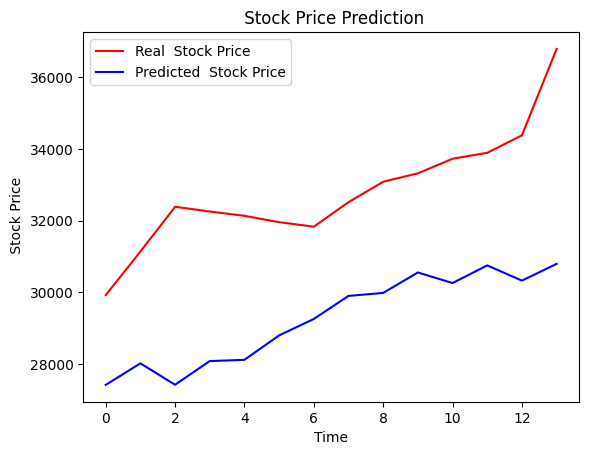

In [157]:
plt.plot(actual_ori, color = 'red', label = 'Real  Stock Price')
plt.plot(predict_ori, color = 'blue', label = 'Predicted  Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

In [ ]:
mymodel.save('Model_future_value.h5')
print('Model Saved!')

# END!!!!